# Using InModeling and Post Hoc XAI techniques for Linear Models (Glass Box)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import shap
from lime.lime_tabular import LimeTabularExplainer
import warnings
from pygam import LinearGAM, s
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay

warnings.filterwarnings("ignore", message="KNOWN BUG: p-values computed in this summary")


In [2]:
data = pd.read_csv("wnba_clean.csv")

In [3]:
data.head()

shot_type  made_shot  shot_value  coordinate_x  \
0                  Jump Shot      False           0           -13   
1  Turnaround Bank Jump Shot      False           0             0   
2         Cutting Layup Shot       True           2           -21   
3         Driving Layup Shot       True           2             0   
4                  Jump Shot       True           3             0   

   coordinate_y  home_score  away_score  qtr  quarter_seconds_remaining  \
0             9           0           0    1                        571   
1             0           0           0    1                        551   
2             2           0           2    1                        538   
3             0           2           2    1                        524   
4            21           2           5    1                        512   

   game_seconds_remaining shot_group   distance  shot_group_encoded  \
0                    2371  Jump Shot  15.811388                   3   
1                    2351  Jump Shot   0.000000                   3   
2                    2338      Layup  21.095023                   1   
3                    2324      Layup   0.000000                   1   
4                    2312  Jump Shot  21.000000                   3   

   shot_type_encoded  
0                 29  
1                  8  
2                 25  
3                 14  
4                 29

In [4]:
selected_features = ['coordinate_x', 'coordinate_y', 'distance', 'shot_group_encoded', 'shot_type_encoded']

In [5]:
X = data[selected_features]
y = data['made_shot']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Linear Regression

In [7]:
# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Mean Squared Error (MSE): 0.23
R-squared (R2): 0.09


### InModeling XAI

              Feature  Coefficient
3  shot_group_encoded     0.024265
4   shot_type_encoded     0.006334
2            distance     0.004696
0        coordinate_x    -0.002705
1        coordinate_y    -0.015276


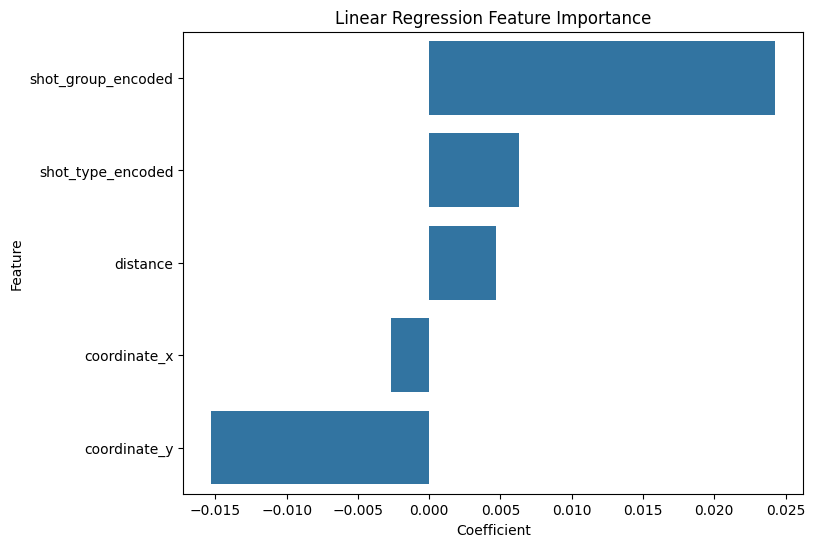

In [8]:
# Visualizing coefficients for feature importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients)

plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Linear Regression Feature Importance')
plt.show()


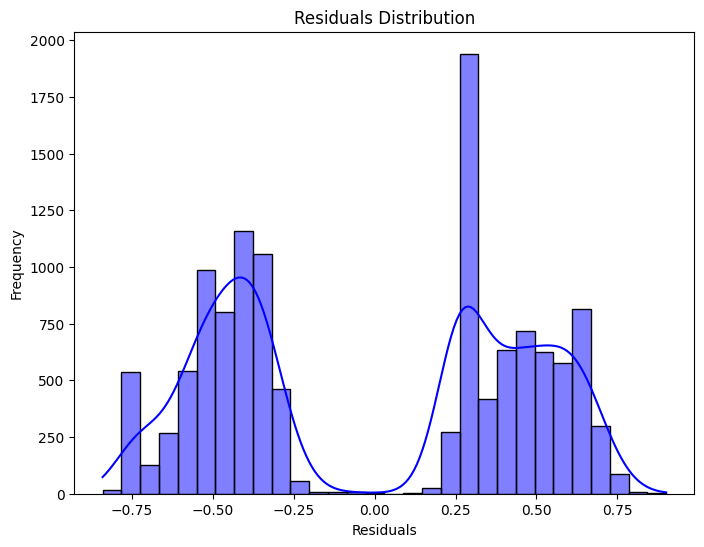

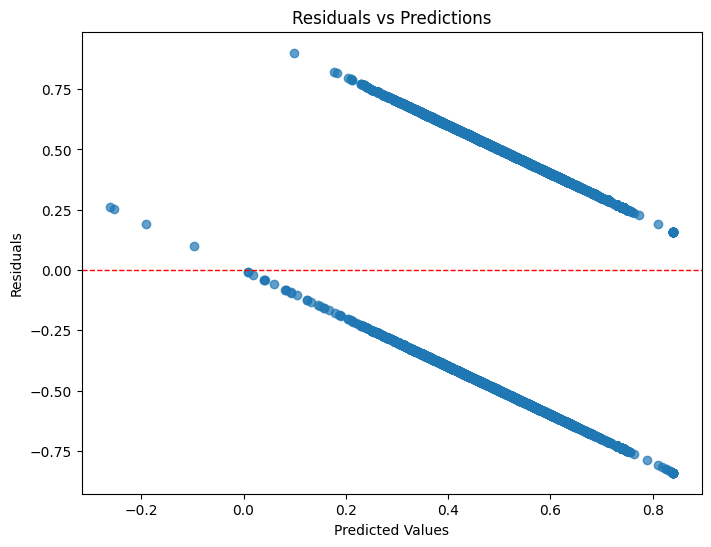

In [9]:
# Residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals vs Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


### Post Hoc XAI

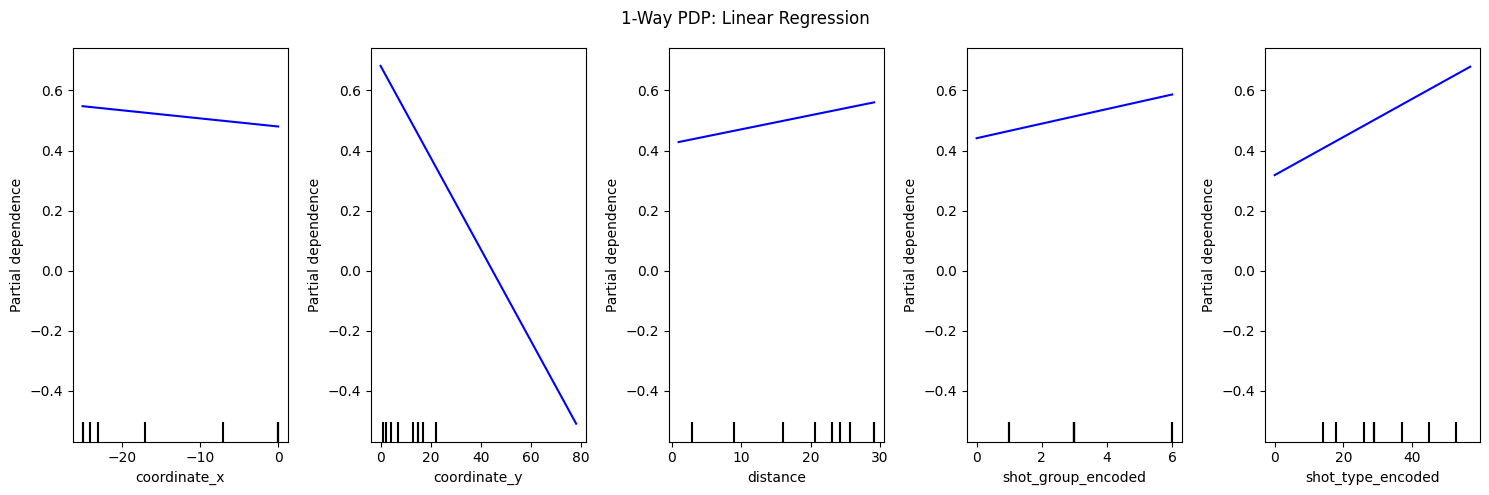

In [10]:

# 1-way PDP for both models (individual features)
features = [0, 1, 2, 3, 4]  # Adjust these to your features' indices
fig, axs = plt.subplots(1, len(features), figsize=(15, 5))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=axs, line_kw={"color": "blue"})
plt.suptitle("1-Way PDP: Linear Regression")
plt.tight_layout()
plt.show()


In [11]:
X_train

coordinate_x  coordinate_y   distance  shot_group_encoded  \
38877           -20             3  20.223748                   3   
22111           -13            15  19.849433                   3   
520              -8             0   8.000000                   3   
10084            -2             1   2.236068                   3   
40933             0             2   2.000000                   1   
...             ...           ...        ...                 ...   
6265            -25            15  29.154759                   6   
11284             0            22  22.000000                   3   
38158           -19            15  24.207437                   3   
860             -25            15  29.154759                   6   
15795           -25             0  25.000000                   5   

       shot_type_encoded  
38877                  9  
22111                 37  
520                   29  
10084                 29  
40933                 35  
...                  ...  
6265                  53  
11284                 29  
38158                 37  
860                   52  
15795                 40  

[29047 rows x 5 columns]

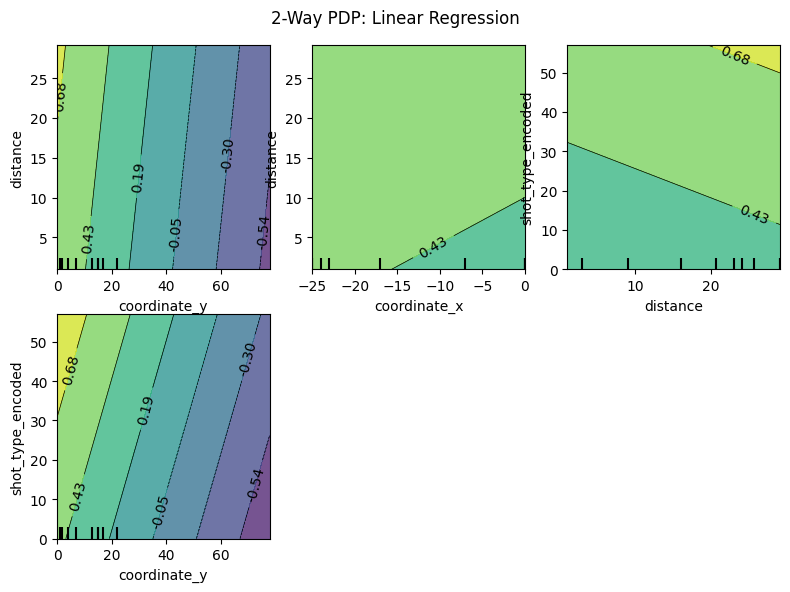

In [12]:
# 2-way PDP for feature interactions
interaction_features = [(1, 2), (0,2), (2,4), (1,4)]  
# For Linear Regression
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(model, X_train, interaction_features, ax=ax)
plt.suptitle("2-Way PDP: Linear Regression")
plt.tight_layout()
plt.show()

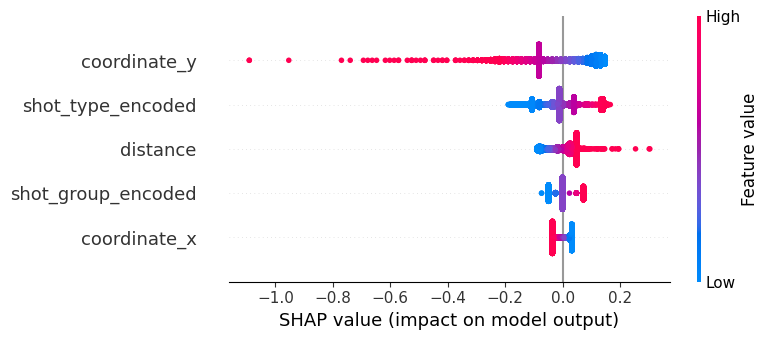

In [13]:
# Initialize SHAP explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)


In [14]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Prediction'],  # Customize as needed
    mode='regression'
)

class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, data):
        return self.model.predict(pd.DataFrame(data, columns=X_train.columns))

# Wrap the model
wrapped_model = ModelWrapper(model)

for i in range(0, 4):
    # Choose a single instance to explain
    instance_idx = i
    instance = X_test.iloc[instance_idx].values
    
    # Generate explanation
    lime_exp = explainer.explain_instance(instance, wrapped_model.predict)
    lime_exp.show_in_notebook(show_table=True)


## Linear GAM

In [15]:
gam = LinearGAM()
gam.fit(X,y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False)

### InModeling XAI

In [16]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     63.4931
Link Function:                     IdentityLink Log Likelihood:                                -70393.7503
Number of Samples:                        41497 AIC:                                           140916.4869
                                                AICc:                                          140916.6908
                                                GCV:                                                0.2168
                                                Scale:                                              0.2162
                                                Pseudo R-Squared:                                   0.1355
Feature Function                  Lam

### Post Hoc XAI

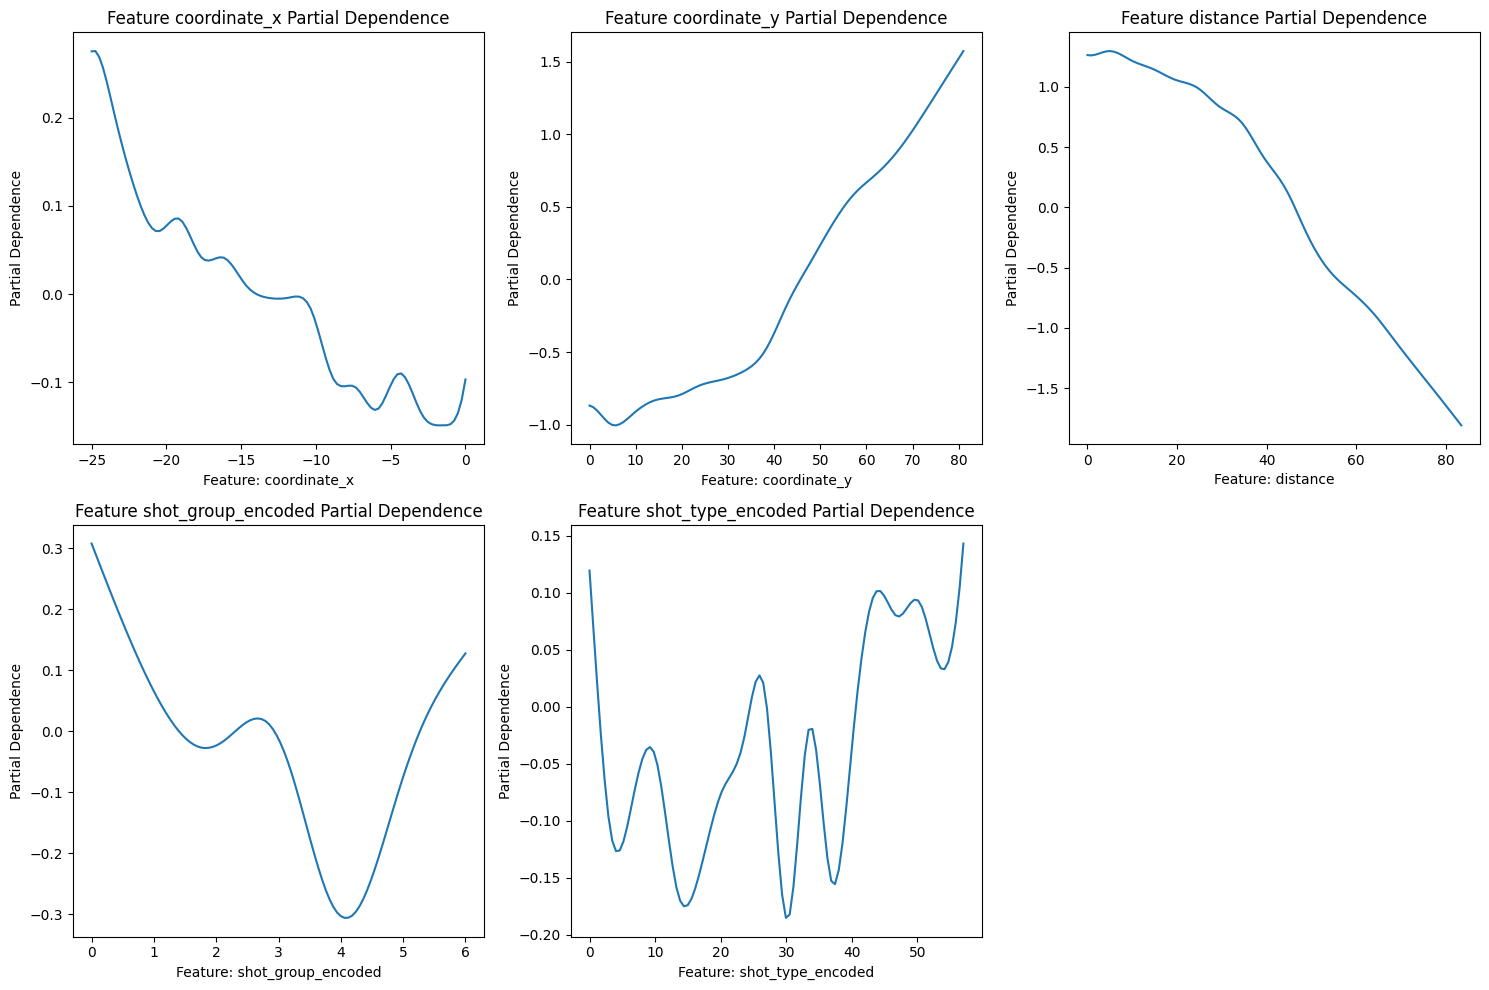

<Figure size 640x480 with 0 Axes>

In [24]:

# Create a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust to match the number of features
axs = axs.flatten()  # Flatten the 2D grid into a 1D array for iteration

# Plot partial dependence for each feature
for i in range(len(axs)):
    if i >= len(X_train.columns):  # Avoid plotting for extra subplots
        axs[i].axis('off')  # Turn off unused subplots
        continue
    XX = gam.generate_X_grid(term=i)  # Generate values for the i-th feature
    axs[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))  # Plot partial dependence
    axs[i].set_title(f'Feature {X_train.columns[i]} Partial Dependence')
    axs[i].set_xlabel(f'Feature: {X_train.columns[i]}')
    axs[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()
plt.savefig("example_plot.png", format='png', dpi=300)

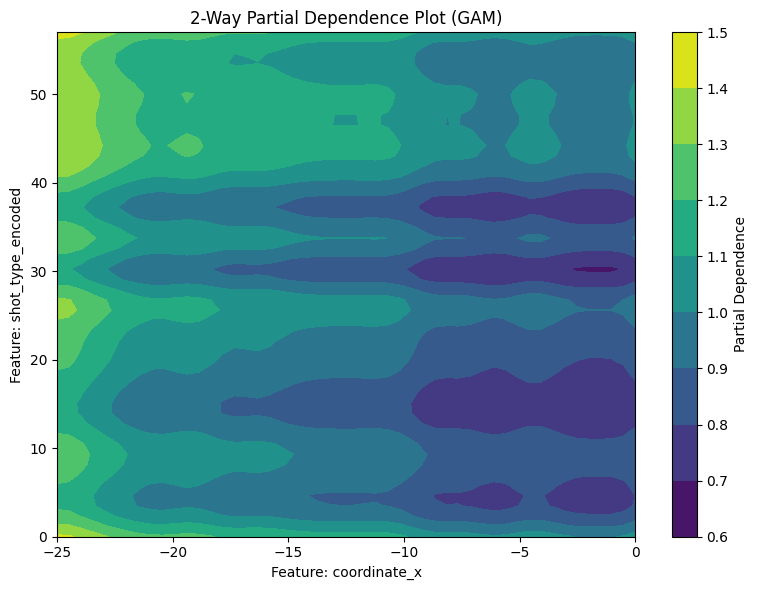

In [18]:
# Select two feature indices for interaction
feature1_idx = 0  
feature2_idx = 4  

# Define the range for each feature
feature1_range = np.linspace(X_train.iloc[:, feature1_idx].min(), X_train.iloc[:, feature1_idx].max(), 50)
feature2_range = np.linspace(X_train.iloc[:, feature2_idx].min(), X_train.iloc[:, feature2_idx].max(), 50)

# Create a grid of values for the two features
feature1_grid, feature2_grid = np.meshgrid(feature1_range, feature2_range)

# Prepare the grid for GAM predictions
grid_data = np.zeros((feature1_grid.size, X_train.shape[1]))
grid_data[:, feature1_idx] = feature1_grid.ravel()
grid_data[:, feature2_idx] = feature2_grid.ravel()

# Predict partial dependence values
pd_values = gam.predict(grid_data).reshape(feature1_grid.shape)

# Plot 2-way Partial Dependence heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(feature1_grid, feature2_grid, pd_values, cmap='viridis')
plt.colorbar(contour, label='Partial Dependence')
plt.xlabel(f'Feature: {X_train.columns[feature1_idx]}')
plt.ylabel(f'Feature: {X_train.columns[feature2_idx]}')
plt.title('2-Way Partial Dependence Plot (GAM)')
plt.tight_layout()
plt.show()

In [19]:
# Predict feature contributions
feature_contributions = np.array([
    gam.partial_dependence(term=i, X=X_test) for i in range(X_test.shape[1])
])

# Transpose to match SHAP's expected shape
shap_values = feature_contributions.T  # Shape: (n_samples, n_features)

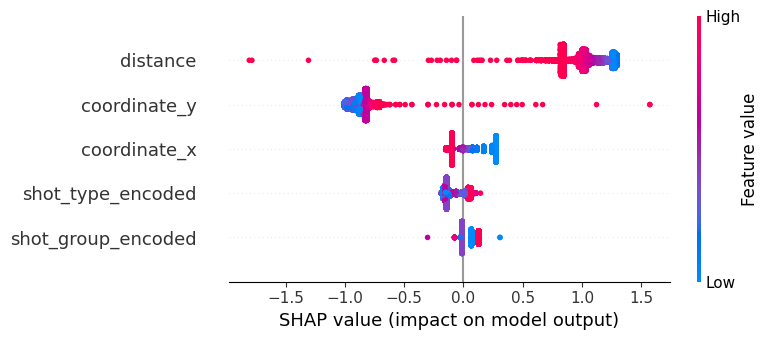

In [20]:


# Convert to SHAP's format
explainer = shap.Explanation(
    values=shap_values,
    base_values=gam.predict(X_test),
    data=X_test,
    feature_names=X_test.columns
)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
